In [1]:
# Setup notebook
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

# Loading the Data

In [2]:
data_folder = 'store_sales_data/'
store_sales = pd.read_csv(
        data_folder + '/train.csv',
        usecols=['store_nbr', 'family', 'date', 'sales'],
        dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        },
        parse_dates=['date'],
        infer_datetime_format=True,)
holidays_events = pd.read_csv(data_folder + 'holidays_events.csv')
oil = pd.read_csv(data_folder + 'oil.csv')
train = pd.read_csv(data_folder + 'train.csv')
test = pd.read_csv(data_folder + 'test.csv')
stores = pd.read_csv(data_folder + 'stores.csv')
transactions = pd.read_csv(data_folder + 'transactions.csv')

# Understanding the Data

In [3]:
from datetime import datetime
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

holidays_events['month'] = pd.DatetimeIndex(holidays_events['date']).month
holidays_events['month_name'] = pd.DatetimeIndex(holidays_events['date']).month_name()


holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
 6   month        350 non-null    int64         
 7   month_name   350 non-null    object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(5)
memory usage: 19.6+ KB


In [4]:
oil['date'] = pd.to_datetime(oil['date'])
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [5]:
train['date'] = pd.to_datetime(train['date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [7]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions.info()
transactions.isna().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          82678 non-null  datetime64[ns]
 1   store_nbr     82678 non-null  float64       
 2   transactions  82678 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.9 MB


2430

In [8]:
store_sales.info()
store_sales.isna().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   store_nbr  category      
 2   family     category      
 3   sales      float32       
dtypes: category(2), datetime64[ns](1), float32(1)
memory usage: 40.1 MB


0

In [9]:
#Scatter plot to the see correlation between average unit sold and oil price each day 
sales_oil = train.groupby('date').mean()['sales']
sales_oil = sales_oil.reset_index()
sales_oil = pd.merge(sales_oil, oil, on ='date', how='left')

# we don't have all the oil prices available, we impute them 
#There are 43 missing values in the oil prices. We will replace these null values with the previous day's price.
previous_price = 93.14

for index, row in sales_oil.iterrows():
    if math.isnan(row['dcoilwtico']):
        sales_oil.loc[sales_oil['date'] == row['date'], 'dcoilwtico'] = previous_price
    else: 
        previous_price = row['dcoilwtico']

In [10]:
sales_oil

,date,sales,dcoilwtico
0,2013-01-01,1.409438,93.14
1,2013-01-02,278.390807,93.14
2,2013-01-03,202.840197,92.97
3,2013-01-04,198.911154,93.12
4,2013-01-05,267.873244,93.12
...,...,...,...
1679,2017-08-11,463.733851,48.81
1680,2017-08-12,444.798280,48.81
1681,2017-08-13,485.768618,48.81
1682,2017-08-14,427.004717,47.59


# Effects of Oil Prices on Sale Prices
## Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. Shipping products to grocery stores all over Ecuador effects the inventory and therefore sales. With a negative trend seen in the scatter plot below, we can see that the higher the oil prices, the lower the average sale numbers are. 

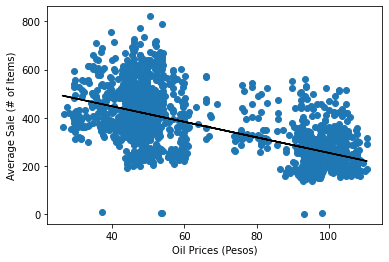

In [11]:
plt.scatter(x=sales_oil["dcoilwtico"], y=sales_oil["sales"])
plt.xlabel('Oil Prices (Pesos)')
plt.ylabel('Average Sale (# of Items)')
#calculate equation for trendline
x, y = sales_oil["dcoilwtico"], sales_oil["sales"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x), color = 'black')

# Amount of Products Sold
## You can see that groceries, beverages, and produce are the top 3 product categories sold in Ecuador. We can predict that these categories would have a much greater weight or affect in our time series analysis rather than categories like baby care and books. 

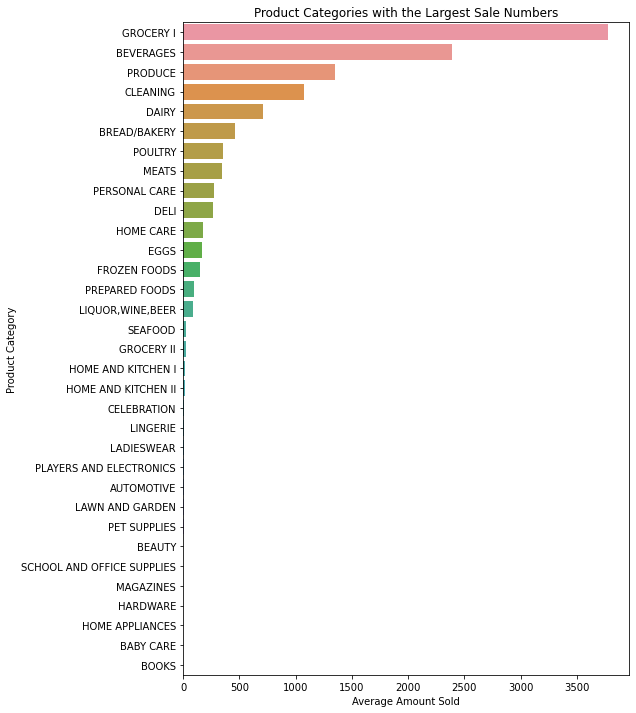

In [12]:
_,_ = plt.subplots(figsize=(8,12))
sns.barplot(data= train.groupby('family')['sales'].agg(['mean']).sort_values(by = 'mean',ascending=False).reset_index(),
            x='mean',
            y='family')
plt.title('Product Categories with the Largest Sale Numbers')
plt.ylabel("Product Category")
plt.xlabel("Average Amount Sold")
plt.show()

# Effects of Holidays
## Holidays are a time to get together and eat amazing foods. This bar graph shows the number of holidays in each month. With a large amount of holidays in April through August and Novermber through December. We can expect a higher number of sales during these times.

December     71
November     49
April        44
May          44
July         36
June         31
August       26
October      15
January      10
March         9
February      8
September     7
Name: month_name, dtype: int64


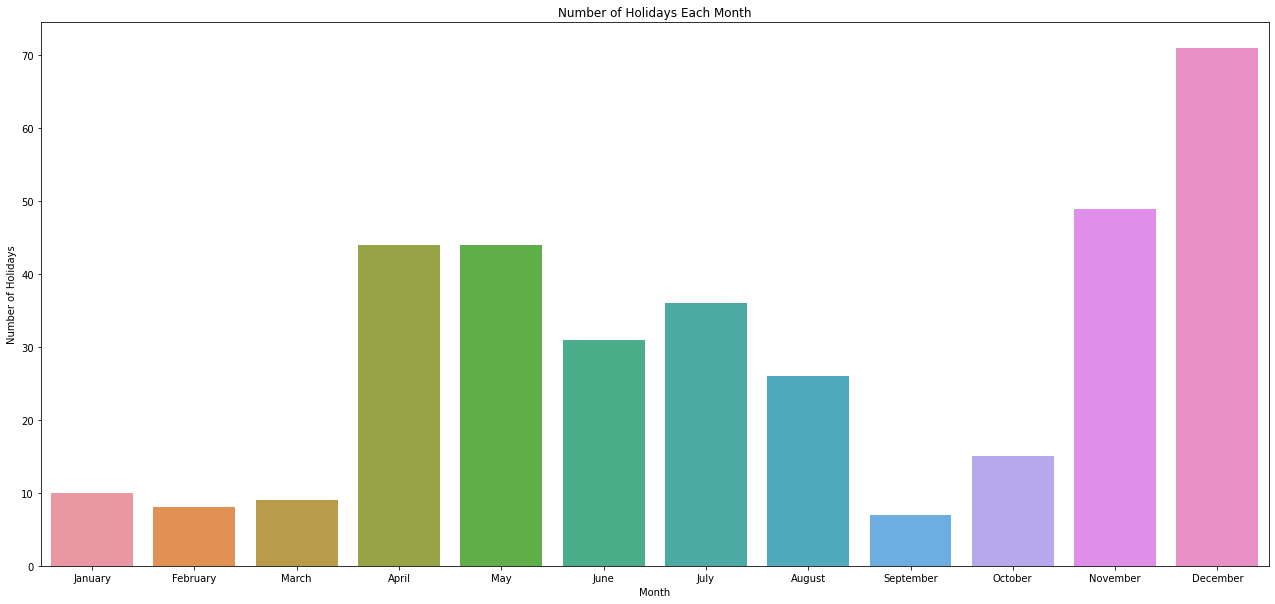

In [13]:
holidays_events['description'].unique()
plt.figure(figsize=(22,10))
holidays_plt = sns.countplot(x = holidays_events['month'])
plt.ylabel('Number of Holidays')
plt.xlabel('Month')
plt.title('Number of Holidays Each Month')
holidays_plt.set_xticklabels(['January','February','March','April','May','June','July','August', 'September', 'October', 'November', 'December'])
print(holidays_events['month_name'].value_counts())

# Number of Transactions
Here is a graph that represents the average number of transactions across all 54 locations. This visually represents the spending tendencies Ecuador, where an increase of about 300-400 more transactions are made during December. This is consistant with the increase in holidays seen in the previous graph. 

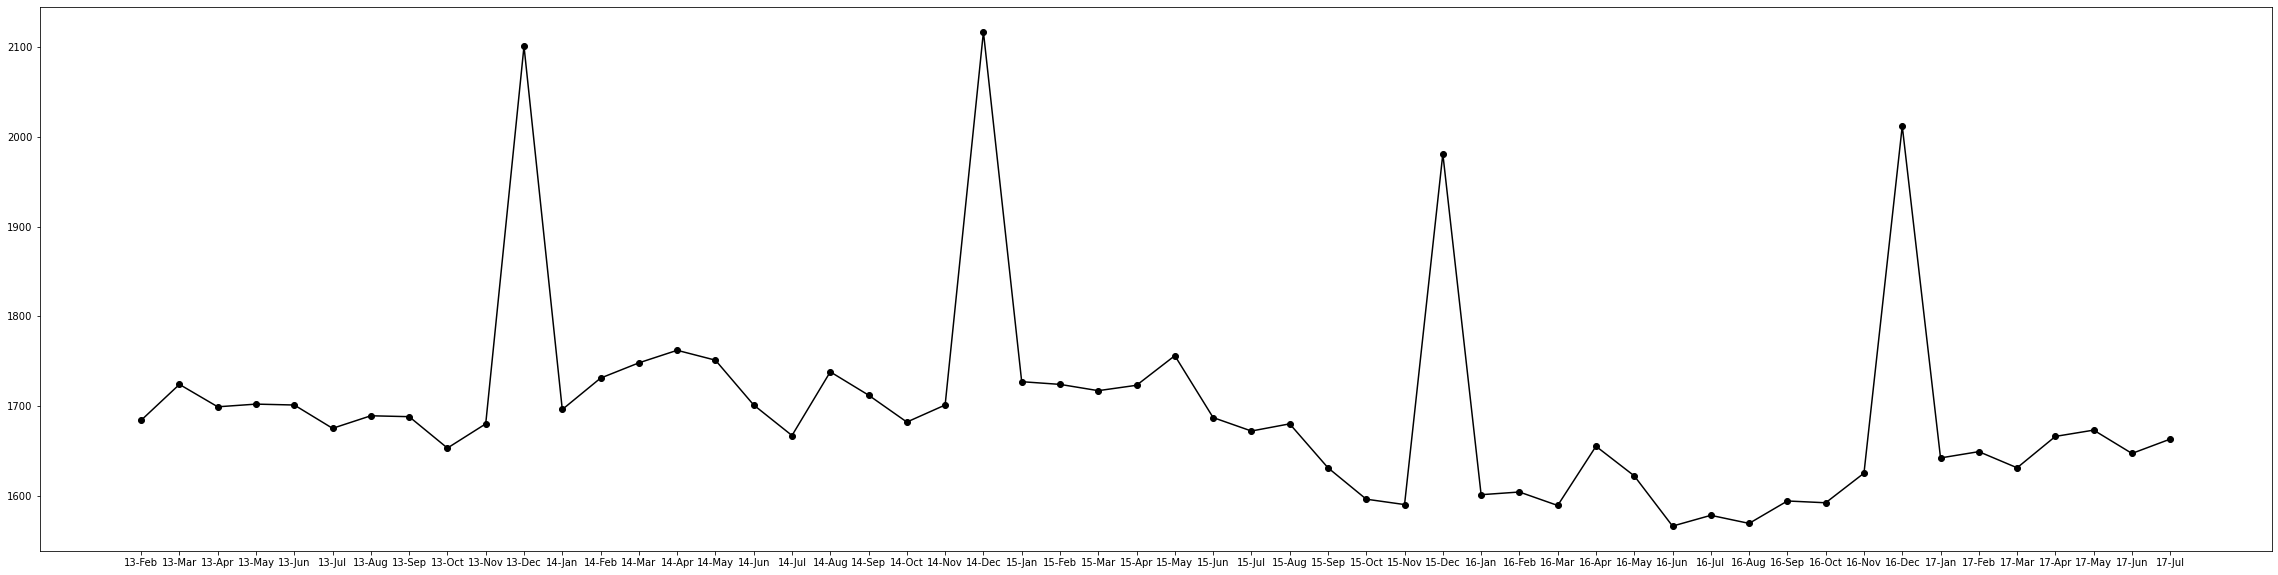

In [23]:
store_trans = pd.read_csv(data_folder + 'avg_transactions.csv')
x=store_trans['date']
y=store_trans['transactions']
plt.figure(figsize=(40,10))
plt.plot(x, y, '-ok')
    
    

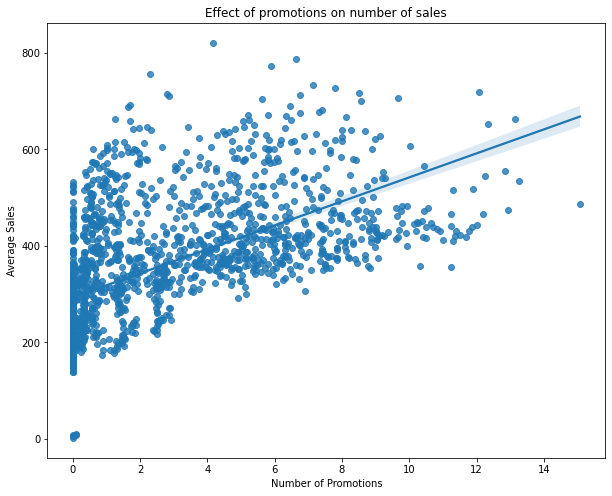

In [26]:
promos = train.groupby('date')[['sales','onpromotion']].mean()

_,ax = plt.subplots(figsize=(10,8))
sns.regplot(data=promos, y='sales', x='onpromotion', ax=ax)
plt.title('Effect of promotions on number of sales')
plt.ylabel('Average Sales')
plt.xlabel('Number of Promotions')
plt.show()

In [28]:
train.shape

(3000888, 6)

In [29]:
%pip install -Uq upgini

Note: you may need to restart the kernel to use updated packages.
